# Inferring Fluid Dynamics with Physics-Informed Neural Networks

This notebook was adapted from [Dr. Seungchul Lee's notebook](https://colab.research.google.com/drive/1L1EmfOFFnoXfCF8YwNxkCflEV0gAScqx?usp=sharing). We sincerely appreciate Dr. Lee's help during the preparation of this tutorial.

In this tutorial, we focus on the inverse problem of not only predicting the flow field around a cylinder but also identifying unknown parameters from observed data. By integrating observational data with governing physical equations, PINNs provide a powerful framework for solving these problems while maintaining consistency with known scientific principles.

## 1. Setup

In [ ]:
# Core libraries
import os
import numpy as np

# PyTorch imports
import torch
import torch.nn as nn
from torch.nn import Linear, Tanh

# Plotting aesthetics
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ipywidgets import interactive, FloatSlider
from IPython.display import display
import ipywidgets as widgets

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Problem definition

We are interested in the flow of a fluid around a solid cylindrical obstacle. The behavior of such a flow is described by the steady-state __Navier-Stokes equations__. These are a set of complex, non-linear partial differential equations (PDEs) that relate the fluid's velocity components ($u$ and $v$ in the $x$ and $y$ directions, respectively) and its pressure ($p$) to its intrinsic physical properties: density ($\rho$) and viscosity ($\mu$).

In this scenario, we assume that the fluid's density ($\rho$) and viscosity ($\mu$) are unknown. However, we have access to a limited amount of experimental data – specifically, sparse measurements of the velocity ($u$ $v$) and pressure ($p$) at a few selected points within the flow field.

The flow is subject to several boundary conditions:
* An __inlet__ where fluid enters the domain at a known velocity.
* An __outlet__ where fluid exits, with a specified pressure.
* __No-slip conditions__ on the solid walls of the channel and the surface of the cylinder, meaning the fluid velocity at these surfaces is zero.



<br>
</center>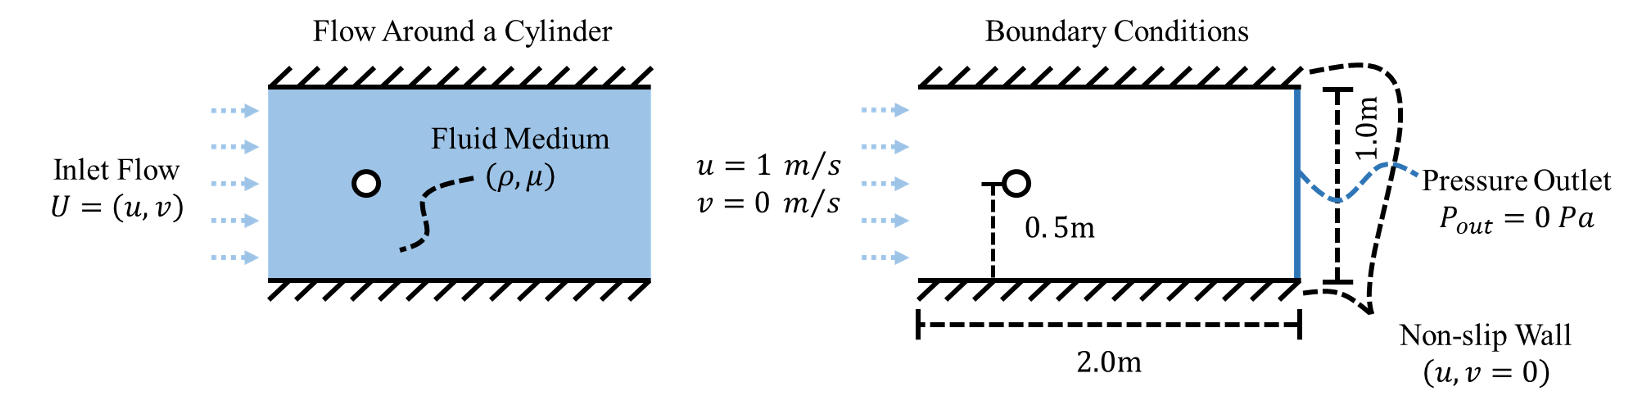

<br>

- Unknown properties

<br>

$$\rho = ? \quad \mu = ?$$

<br>

- Partial differential equations & boundary conditions

<br>

$$
\color{red}\rho\left(u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} + \frac{1}{\color{red}\rho}\frac{\partial p}{\partial x}   \right) - \color{red}\mu\left( \frac{\partial^2u}{\partial^2 x} + \frac{\partial^2u}{\partial^2 y}\right) = 0$$

<br>

$$
\color{red}\rho\left(u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} + \frac{1}{\color{red}\rho}\frac{\partial p}{\partial y}   \right) - \color{red}\mu\left( \frac{\partial^2v}{\partial^2 x} + \frac{\partial^2v}{\partial^2 y}\right) = 0$$

<br>

- Inlet boundary condition ($x=-0.5$):

<br>

$$u|_{x = -0.5} = 1$$

- Outlet boundary condition ($x=1.5$):

<br>

$$v|_{x = 1.5} = 0$$
$$p|_{x = 1.5} = 0$$

- Non-slip boundary condition ($y=\pm 0.5$):

<br>

$$u|_{y = \pm 0.5} = 0$$
$$v|_{y = \pm 0.5} = 0$$

<center>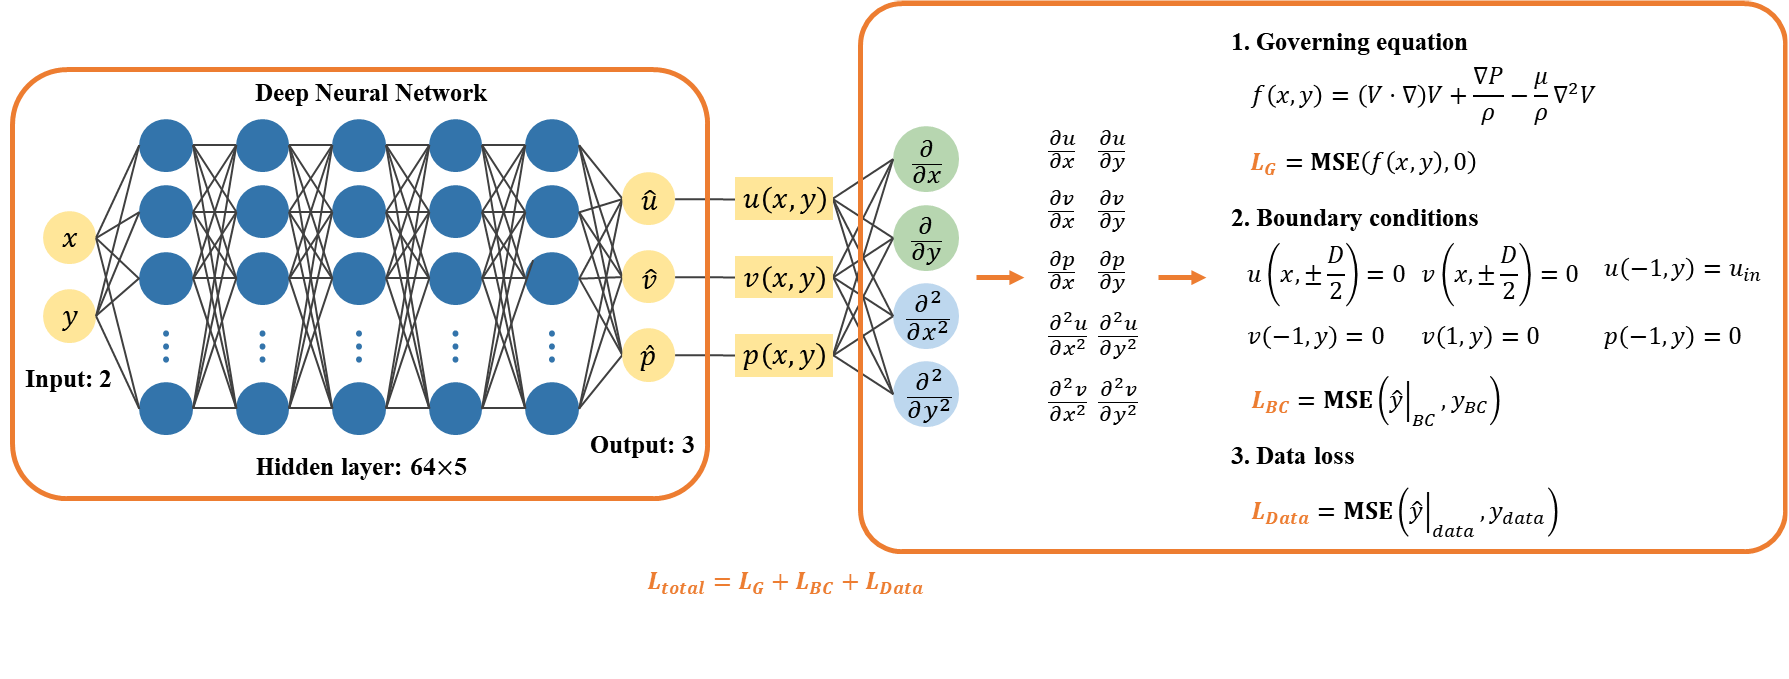

In this problem, the density $\rho$ is 1 and the viscosity $\mu$ is 0.01. Of course, these two values are assumed to be unknown throughout this example.


## Data loading and generation

We download some observational data.
- [XY_domain](https://github.com/MIDAS-KGML/pre-workshop/blob/main/data/XY_domain.npy)
- [gt_domain](https://github.com/MIDAS-KGML/pre-workshop/blob/main/data/gt_domain.npy)


In [ ]:
# download data into working directory (temporary)
!wget -q -O XY_domain.npy https://raw.githubusercontent.com/MIDAS-KGML/pre-workshop/main/data/XY_domain.npy
!wget -q -O gt_domain.npy https://raw.githubusercontent.com/MIDAS-KGML/pre-workshop/main/data/gt_domain.npy

We have a grid in the problem domain, with numerical solutions at each grid point.

In [ ]:
XY_domain = np.load('XY_domain.npy')
gt_domain = np.load('gt_domain.npy')
print(XY_domain.shape)
print(gt_domain.shape)

(19692, 2)
(19692, 3)


Assume that there were only 49 sensors randomly placed in the domain. Retrieve the x-velocity, y-velocity, and pressure at these locations.

XY obs: (49, 2)
GT obs: (49, 3)


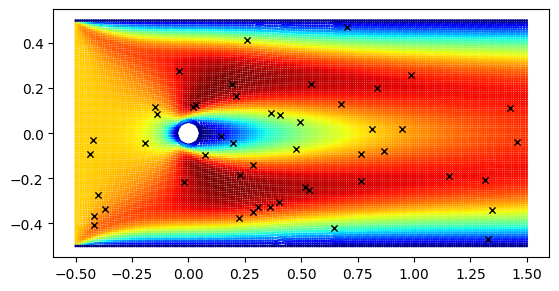

In [ ]:
np.random.seed(42)
idx_obs = np.random.choice(len(XY_domain), int(49), replace = False)
XY_obs = XY_domain[idx_obs]
gt_obs = gt_domain[idx_obs]
print('XY obs: {}'.format(XY_obs.shape))
print('GT obs: {}'.format(gt_obs.shape))

plt.scatter(XY_domain[:, 0], XY_domain[:, 1], c = gt_domain[:, 0], s = 1, cmap = 'jet')
plt.scatter(XY_obs[:, 0], XY_obs[:, 1], marker = 'x', linewidths = 1, s = 20, c = 'k')
plt.axis('scaled')
plt.show()

We will use the grid points in the domain as part of the collocation points. We then define collocation points for boundary conditions.


In [ ]:
# Boundary Conditions
bc_top_x = np.linspace(-0.5, 1.5, 200).reshape(-1, 1)
bc_top_y = 0.5 * np.ones_like(bc_top_x).reshape(-1, 1)

bc_bottom_x = np.linspace(-0.5, 1.5, 200).reshape(-1, 1)
bc_bottom_y = -0.5 * np.ones_like(bc_bottom_x).reshape(-1, 1)

bc_inlet_y = np.linspace(-0.5, 0.5, 100).reshape(-1, 1)
bc_inlet_x = -0.5 * np.ones_like(bc_inlet_y).reshape(-1, 1)

bc_outlet_y = np.linspace(-0.5, 0.5, 100).reshape(-1, 1)
bc_outlet_x = 1.5 * np.ones_like(bc_outlet_y).reshape(-1, 1)

XY_top = np.concatenate((bc_top_x, bc_top_y), 1)
XY_bottom = np.concatenate((bc_bottom_x, bc_bottom_y), 1)
XY_inlet = np.concatenate((bc_inlet_x, bc_inlet_y), 1)
XY_outlet = np.concatenate((bc_outlet_x, bc_outlet_y), 1)

radius = 0.05 # known radius of the cylindrical obstacle
theta = np.linspace(0, 2 * np.pi, 200)
bc_cylinder_x = (0 + radius * np.cos(theta)).reshape(-1, 1)
bc_cylinder_y = (0 + radius * np.sin(theta)).reshape(-1, 1)
XY_cylinder = np.concatenate((bc_cylinder_x, bc_cylinder_y), 1)

XY_wall = np.concatenate((XY_top, XY_bottom, XY_cylinder))

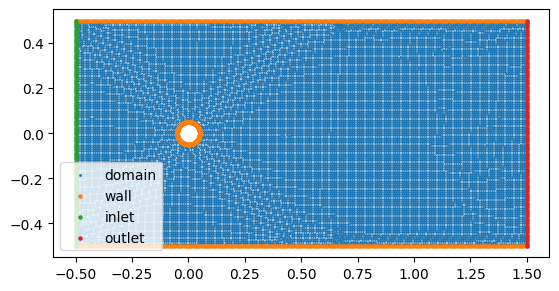

In [ ]:
plt.scatter(XY_domain[:, 0], XY_domain[:, 1], s = 1, label = 'domain')
plt.scatter(XY_wall[:, 0], XY_wall[:, 1], s = 5, label = 'wall')
plt.scatter(XY_inlet[:, 0], XY_inlet[:, 1], s = 5, label = 'inlet')
plt.scatter(XY_outlet[:, 0], XY_outlet[:, 1], s = 5, label = 'outlet')
plt.axis('scaled')
plt.legend()
plt.show()

## Neural Network



In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.net = nn.Sequential(
        Linear(2, 256),
        Tanh(),
        Linear(256, 256),
        Tanh(),
        Linear(256, 256),
        Tanh(),
        Linear(256, 256),
        Tanh(),
        Linear(256, 3),
        )

        # Add trainable physical parameters
        self.rho = nn.Parameter(torch.tensor(1.0))
        self.vis = nn.Parameter(torch.tensor(1.0))

        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.float()
        output = self.net(x)
        u, v, p = output[:, 0:1], output[:, 1:2], output[:, 2:3]
        return u, v, p

> 💡 Exploration
>
> Here, we treat density and viscosity as real numbers without constraints. You can impose an additional constraint to ensure that they are positive. We have written you a function to get you started.
> ```
> import torch.nn.functional as F
>
> class Network(nn.Module):
>   # ... omit ...
>   def get_parameters(self):
>       rho = F.relu(self._rho)
>       vis = F.relu(self._vis)
>       return rho, vis
> ```
>
> After going through this tutorial, please explore how to use this function to add this constraint.

## PINN



In [ ]:
def derivative(output, input):
    df = torch.autograd.grad(output, input, grad_outputs = torch.ones_like(output).to(device), create_graph = True)[0]
    df_x = df[:, 0:1]
    df_y = df[:, 1:2]
    return df_x, df_y

Define functions to compute physics loss.

2D Navier-Stokes Equations & boundary conditions (for steady state)

$$
\begin{align*}
\rho \left(u{\partial u \over \partial x} + v{\partial u \over \partial y} + {1 \over \rho}{\partial p \over \partial x}\right) - \mu \ \left({\partial^2 u \over {\partial x^2}} + {\partial^2 u \over {\partial y^2}}\right) &= 0\\\\
\rho \left(u{\partial v \over \partial x} + v{\partial v \over \partial y} + {1 \over \rho}{\partial p \over \partial y}\right) - \mu \ \left({\partial^2 v \over {\partial x^2}} + {\partial^2 v \over {\partial y^2}}\right) &= 0\\\\
{\partial u \over \partial x} + {\partial v \over \partial y} &= 0
\end{align*}
$$

<br>

In [ ]:
def PDE(model, XY_domain):

    u, v, p = model(XY_domain)

    du_x, du_y = derivative(u, XY_domain)
    du_xx, _ = derivative(du_x, XY_domain)
    _, du_yy =  derivative(du_y, XY_domain)

    dv_x, dv_y = derivative(v, XY_domain)
    dv_xx, _ = derivative(dv_x, XY_domain)
    _, dv_yy = derivative(dv_y, XY_domain)

    dp_x, dp_y = derivative(p, XY_domain)

    rho = model.rho
    vis = model.vis

    pde_u = rho * (u * du_x + v * du_y) + dp_x - vis * (du_xx + du_yy)
    pde_v = rho * (u * dv_x + v * dv_y) + dp_y - vis * (dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    return pde_u, pde_v, pde_cont


- Two Dirichlet boundary conditions on the plate boundary (no-slip condition),

<br>

$$u(x,y) = 0, \quad v(x,y) = 0 \qquad \text{at} \quad y = \frac{D}{2} \ \; \text{or} \; -\frac{D}{2}$$

<br>


- Two Dirichlet boundary conditions at the cylinder boundary

<br>

$$u(\text{cylinder}) = 0, \quad v(\text{cylinder}) = 0$$

<br>

- Two Dirichlet boundary conditions at the inlet boundary

<br>

$$u(-1,y) = u_{\text{in}} = 1, \quad v(-1,y) = 0$$

<br>

- Two Dirichlet boundary conditions at the outlet boundary

<br>

$$p(1,y) = 0, \quad v(1,y) = 0$$

<br>

In [ ]:
def BC_wall(model, XY_wall):
    u_wall, v_wall, _ = model(XY_wall)
    return u_wall, v_wall

def BC_inlet(model, XY_inlet):
    u_inlet, v_inlet, _ = model(XY_inlet)
    u_inlet = u_inlet - torch.ones_like(u_inlet).to(device)
    return u_inlet, v_inlet

def BC_outlet(model, XY_outlet):
    _, v_outlet, p_outlet = model(XY_outlet)
    return v_outlet, p_outlet

$$
L_{\text{data}} = \frac{1}{N_{\text{data}}} \sum \left( \left(u - \hat u \right)^2 + \left(v - \hat v \right)^2 + \left(p - \hat p \right)^2 \right)
$$

$$
L = \omega_{\text{data}}  L_{\text{data}} + \omega_{\text{PDE}} L_{\text{PDE}} + \omega_{\text{BC}} L_{\text{BC}}
$$

In [ ]:
# PINN Wrapper
class PINNWrapper:
    def __init__(self, model):
        self.model = model

    def forward(self, XY_domain, XY_wall, XY_inlet, XY_outlet, XY_obs, gt_obs):
        loss_fn = nn.MSELoss()

        # PDE loss
        PDE_u, PDE_v, PDE_cont = PDE(self.model, XY_domain)
        loss_PDE_u = loss_fn(PDE_u, torch.zeros_like(PDE_u))
        loss_PDE_v = loss_fn(PDE_v, torch.zeros_like(PDE_v))
        loss_PDE_cont = loss_fn(PDE_cont, torch.zeros_like(PDE_cont))
        loss_pde = loss_PDE_u + loss_PDE_v + loss_PDE_cont

        # Boundary condition loss
        u_wall, v_wall = BC_wall(self.model, XY_wall)
        u_inlet, v_inlet = BC_inlet(self.model, XY_inlet)
        v_outlet, p_outlet = BC_outlet(self.model, XY_outlet)

        loss_bc = (
            loss_fn(u_wall, torch.zeros_like(u_wall)) +
            loss_fn(v_wall, torch.zeros_like(v_wall)) +
            loss_fn(u_inlet, torch.zeros_like(u_inlet)) +
            loss_fn(v_inlet, torch.zeros_like(v_inlet)) +
            loss_fn(v_outlet, torch.zeros_like(v_outlet)) +
            loss_fn(p_outlet, torch.zeros_like(p_outlet))
        )

        # Data loss
        u_obs, v_obs, p_obs = self.model(XY_obs)
        loss_data = (
            loss_fn(u_obs, gt_obs[:, 0:1]) +
            loss_fn(v_obs, gt_obs[:, 1:2]) +
            loss_fn(p_obs, gt_obs[:, 2:3])
        )

        return loss_pde, loss_bc, loss_data

## Training and prediction

In [ ]:
# Training loop
def train(model_wrapper, optimizer, XY_domain, XY_wall, XY_inlet, XY_outlet, XY_obs, gt_obs,
          max_epoch=10000, device='cpu', save = False):

    model = model_wrapper.model.to(device)
    model.train()

    # Move data to device
    XY_domain = torch.tensor(XY_domain, dtype = torch.float32, requires_grad = True).to(device)
    XY_wall = torch.tensor(XY_wall, dtype = torch.float32, requires_grad = True).to(device)
    XY_inlet = torch.tensor(XY_inlet, dtype = torch.float32, requires_grad = True).to(device)
    XY_outlet = torch.tensor(XY_outlet, dtype = torch.float32, requires_grad = True).to(device)
    XY_obs = torch.tensor(XY_obs, dtype = torch.float32, requires_grad = True).to(device)
    gt_obs = torch.tensor(gt_obs, dtype = torch.float32, requires_grad = True).to(device)

    loss_list = []
    rho_list = []
    vis_list = []

    if save == True:
        os.makedirs('saved_model', exist_ok=True)
    epoch = 0
    while epoch <= max_epoch:
        loss_pde, loss_bc, loss_data = model_wrapper.forward(
            XY_domain, XY_wall, XY_inlet, XY_outlet, XY_obs, gt_obs
        )

        loss = loss_pde + loss_bc + 10 * loss_data

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        rho_list.append(model.rho.item())
        vis_list.append(model.vis.item())

        if epoch % 5 == 0:
            print(f'EPOCH : {epoch:6d}/{max_epoch:6d} | '
                  f'Loss_PDE : {loss_pde.item():.4f} | '
                  f'Loss_BC : {loss_bc.item():.4f} | '
                  f'Loss_DATA : {loss_data.item():.4f} | '
                  f'Rho : {model.rho.item():.4f} | '
                  f'Vis : {model.vis.item():.4f}')
            PLOT(model, XY_domain, rho_list, vis_list)

        if epoch % 500 == 0 & save == True:
            torch.save(model, 'model_'+str(epoch)+'.pt')
            np.save('rho_list_'+str(epoch)+'.npy', rho_list)
            np.save('vis_list_'+str(epoch)+'.npy', vis_list)

        epoch += 1

In [ ]:
def PLOT(model, XY_domain, rho_list, vis_list):
    pred = model(XY_domain)

    plt.figure(figsize = (9, 2))
    plt.subplot(1, 3, 1)
    plt.title('CFD')
    plt.scatter(XY_domain[:, 0].detach().cpu().numpy(),
                XY_domain[:, 1].detach().cpu().numpy(),
                c = gt_domain[:, 0],
                s = 0.1, cmap = 'jet')
    plt.axis('scaled')

    plt.subplot(1, 3, 2)
    plt.title('Prediction')
    plt.scatter(XY_domain[:, 0].detach().cpu().numpy(),
                XY_domain[:, 1].detach().cpu().numpy(),
                c = pred[0].detach().cpu().numpy(),
                s = 0.1, cmap = 'jet')
    plt.axis('scaled')

    plt.subplot(1, 3, 3)
    plt.title('Error')
    plt.scatter(XY_domain[:, 0].detach().cpu().numpy(),
                XY_domain[:, 1].detach().cpu().numpy(),
                c = np.abs(pred[0].detach().cpu().numpy() - gt_domain[:, 0:1]),
                s = 0.1, cmap = 'jet')
    plt.axis('scaled')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (6, 2))
    plt.subplot(1, 2, 1)
    plt.title('Rho Prediction')
    plt.plot(rho_list)

    plt.subplot(1, 2, 2)
    plt.title('Vis Prediction')
    plt.plot(vis_list)
    plt.tight_layout()
    plt.show()
    clear_output(wait = True)

In [ ]:
network = Network().to(device)
pinn_wrapper = PINNWrapper(network)

optimizer = torch.optim.Adam(params = network.parameters(), lr = 1e-4)

train(pinn_wrapper, optimizer, XY_domain, XY_wall, XY_inlet, XY_outlet, XY_obs, gt_obs, max_epoch=50000, device = device, save = False)

EPOCH :    140/ 50000 | Loss_PDE : 0.0253 | Loss_BC : 0.9739 | Loss_DATA : 0.1372 | Rho : 0.9960 | Vis : 0.9993


KeyboardInterrupt: 

Please feel free to interrupt the training after you observe its progress for a while. We have done the model training for 50000 epochs and saved the trained models.
- [saved_model](https://github.com/MIDAS-KGML/pre-workshop/blob/main/data/saved_model.zip)

In [ ]:
# download data into working directory (temporary)
!wget -q -O saved_model.zip https://raw.githubusercontent.com/MIDAS-KGML/pre-workshop/main/data/saved_model.zip
!unzip -q saved_model.zip -d saved_model/

In [ ]:
def interactive_plot(epoch, XY_domain, gt_domain):
    rho_path = f'saved_model/rho_list_{epoch}.npy'
    vis_path = f'saved_model/vis_list_{epoch}.npy'

    rho_list = np.load(rho_path, allow_pickle=True).tolist()
    vis_list = np.load(vis_path, allow_pickle=True).tolist()

    with torch.no_grad():
        clear_output(wait=True) # Clear previous output before showing the new plot
        print('EPOCH: {}'.format(epoch))
        print('Predicted RHO: {:.4f}, Predicted VIS: {:.4f}\n\n'.format(rho_list[-1], vis_list[-1]))

        model = torch.load(f'saved_model/model_{epoch}.pt', weights_only=False)
        XY_domain = torch.tensor(XY_domain, dtype = torch.float32, requires_grad = True).clone().detach()

        PLOT(model, XY_domain, rho_list, vis_list)

# Create a slider for epochs
epoch_slider = widgets.IntSlider(min=0, max=50000, step=500, description='Epoch:')

# Create the interactive widget
interactive_plot_widget = interactive(interactive_plot, epoch=epoch_slider, XY_domain=widgets.fixed(XY_domain), gt_domain=widgets.fixed(gt_domain))

# Display the interactive widget
display(interactive_plot_widget)

interactive(children=(IntSlider(value=0, description='Epoch:', max=50000, step=500), Output()), _dom_classes=(…